In [1]:
import torch as th
import torch.nn as nn
import torch.nn.functional as F
import sys
import os
import h5py
import numpy as np

from vit_pytorch import ViT

sys.path.append("/home/lord225/pyrepos/explain-rl")

from ppo import PPO
import procgenwrapper

MODEL_PATH = "/home/lord225/pyrepos/explain-rl/preserve"
DATA_PATH = "/home/lord225/pyrepos/explain-rl/explain/records"

MODEL_NAME = "20250418-212536-WhenFactBe_69_v4.2"

MODEL_PATH = os.path.join(MODEL_PATH, "20250425-150403-StopHealthActually_16_v4.5")
DATA_PATH = os.path.join(DATA_PATH, MODEL_NAME+"_replay.h5")

venv = procgenwrapper.ProcGenWrapper("starpilot", human=False, collect_seg=True)

model = PPO.load(MODEL_PATH,
                    env=venv, 
                    print_system_info=True,
                    custom_objects={
                        "ViT":ViT,
                    })

dataset = h5py.File(DATA_PATH, "r")

observations = np.array(dataset["observations"])
actions = np.array(dataset["actions"])
rewards = np.array(dataset["rewards"])
dones = np.array(dataset["dones"])
seg_observations = np.array(dataset["seg_observations"])
next_observations = np.array(dataset["next_observations"])

dataset.close() 

print(observations.shape)

net = model.policy
vit = net.mlp_extractor.policy_net[1]
vit


2025-05-22 22:22:02.128990: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-05-22 22:22:02.129163: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-05-22 22:22:02.162580: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-22 22:22:02.243711: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-05-22 22:22:03.039808: W tensorflow/compiler/tf2

building procgen...done
== CURRENT SYSTEM INFO ==
- OS: Linux-5.15.167.4-microsoft-standard-WSL2-x86_64-with-glibc2.39 # 1 SMP Tue Nov 5 00:21:55 UTC 2024
- Python: 3.9.21
- Stable-Baselines3: 2.5.0
- PyTorch: 2.6.0+cu124
- GPU Enabled: True
- Numpy: 1.26.4
- Cloudpickle: 1.2.2
- Gymnasium: 1.0.0
- OpenAI Gym: 0.15.7

== SAVED MODEL SYSTEM INFO ==
- OS: Linux-5.15.167.4-microsoft-standard-WSL2-x86_64-with-glibc2.39 # 1 SMP Tue Nov 5 00:21:55 UTC 2024
- Python: 3.9.21
- Stable-Baselines3: 2.5.0
- PyTorch: 2.6.0+cu124
- GPU Enabled: True
- Numpy: 1.26.4
- Cloudpickle: 1.2.2
- Gymnasium: 1.0.0
- OpenAI Gym: 0.15.7

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.
(10000, 64, 64, 9)


ViT(
  (to_patch_embedding): Sequential(
    (0): Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=4, p2=4)
    (1): LayerNorm((144,), eps=1e-05, elementwise_affine=True)
    (2): Linear(in_features=144, out_features=64, bias=True)
    (3): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
  )
  (dropout): Dropout(p=0.0, inplace=False)
  (transformer): Transformer(
    (norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    (layers): ModuleList(
      (0-3): 4 x ModuleList(
        (0): Attention(
          (norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
          (attend): Softmax(dim=-1)
          (dropout): Dropout(p=0.1, inplace=False)
          (to_qkv): Linear(in_features=64, out_features=1152, bias=False)
          (to_out): Sequential(
            (0): Linear(in_features=384, out_features=64, bias=True)
            (1): Dropout(p=0.1, inplace=False)
          )
        )
        (1): FeedForward(
          (net): Sequential(
            (0): Layer

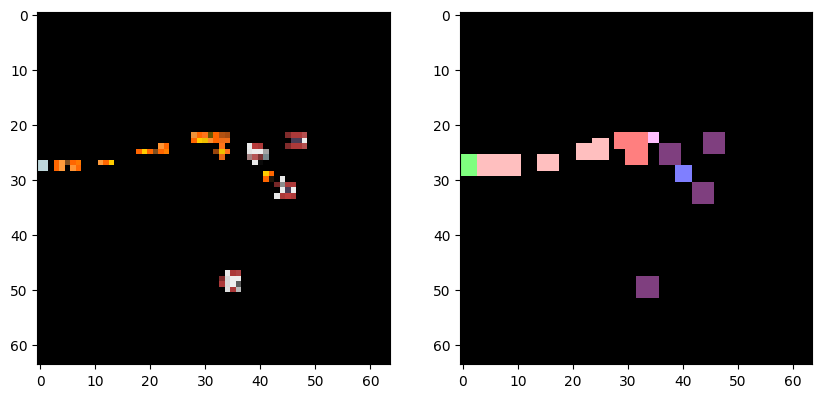

In [2]:
import matplotlib.pyplot as plt

def get_img(obs):
    return obs[:, :, 6:9]

ax, fig = plt.subplots(1, 2, figsize=(10, 5))

fig[0].imshow(get_img(observations[120]))
fig[1].imshow(seg_observations[120], vmin=0, vmax=14)

plt.show()

In [3]:
# Reshape the observations to match the expected input shape
obs_tensor = th.tensor(observations[:1].reshape((1, -1)), dtype=th.float32, device=net.device)

# Pass the tensor through the action_net
features_a, features_b = net.mlp_extractor(obs_tensor)

print(features_a.shape, features_b.shape)

torch.Size([1, 64]) torch.Size([1, 64])


In [4]:
# Get the action logits
action_logits = net.action_net(features_a)

print(action_logits.shape)

torch.Size([1, 15])


In [5]:
from vit_pytorch.extractor import Extractor
from vit_pytorch.recorder import Recorder

extractor = Extractor(vit).cpu()
recorder = Recorder(vit).cpu()

In [6]:
probas, extracted = extractor(th.tensor(observations[:1]).permute(0, 3, 1, 2).float().cpu())

probas.shape, extracted.shape

(torch.Size([1, 64]), torch.Size([1, 257, 64]))

In [7]:
probas, attention = recorder(th.tensor(observations[:1]).permute(0, 3, 1, 2).float().cpu())

probas.shape, attention.shape

(torch.Size([1, 64]), torch.Size([1, 4, 6, 257, 257]))

In [8]:
import cv2
def attention_map(attention, image):
    # avg attention over heads
    attention = np.array(attention).mean(axis=1)

    grid_size = int(np.sqrt(attention.shape[-1] - 1))
    num_layers = attention.shape[0]
    num_heads = attention.shape[1]
    reshaped = attention.reshape(
        (num_layers, num_heads, grid_size**2 + 1, grid_size**2 + 1)
    )

    # From Appendix D.6 in the paper ...
    # Average the attention weights across all heads.
    reshaped = reshaped.mean(axis=1)

    # From Section 3 in https://arxiv.org/pdf/2005.00928.pdf ...
    # To account for residual connections, we add an identity matrix to the
    # attention matrix and re-normalize the weights.
    reshaped = reshaped + np.eye(reshaped.shape[1])
    reshaped = reshaped / reshaped.sum(axis=(1, 2))[:, np.newaxis, np.newaxis]

    # Recursively multiply the weight matrices
    v = reshaped[-1]
    for n in range(1, len(reshaped)):
        v = np.matmul(v, reshaped[-1 - n])

    # Attention from the output token to the input space.
    mask = v[0, 1:].reshape(grid_size, grid_size)
    mask = mask / mask.max()
    return mask

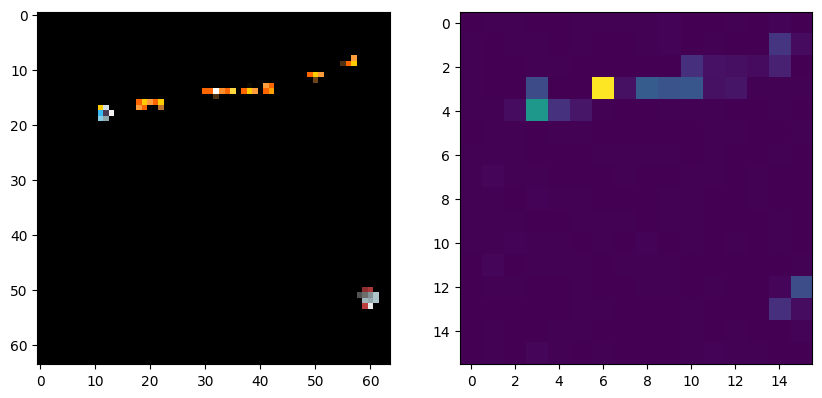

In [9]:
recorder = recorder.cpu()
frame = 304

obs = th.tensor(observations[frame]).reshape(-1, 64, 64, 9).permute(0, 3, 1, 2).float().cpu()

probas, attention = recorder(obs)

map = attention_map(attention.cpu().detach().numpy(), observations[frame])

# plot both
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(get_img(observations[frame]))
ax[1].imshow(map)

plt.show()

In [10]:
import imageio
import tqdm


def generate_attention_gif(observations, filename='attention.gif', duration=0.1):
    frames = []
    for i in tqdm.tqdm(range(len(observations))):
        obs = th.tensor(observations[i]).reshape(-1, 64, 64, 9).permute(0, 3, 1, 2).float().cpu()
        probas, attention = recorder(obs)
        map = attention_map(attention.cpu().detach().numpy(), observations[i])
        
        fig, ax = plt.subplots(1, 2, figsize=(10, 5))
        ax[0].imshow(get_img(observations[i]))
        ax[1].imshow(map)
        plt.close(fig)
        
        fig.canvas.draw()
        image = np.frombuffer(fig.canvas.buffer_rgba(), dtype='uint8')
        image = image.reshape(fig.canvas.get_width_height()[::-1] + (4,))
        frames.append(image)
    # Save the frames as a gif
    imageio.mimsave(filename, frames, duration=duration, loop=0)
    

filename = f"attention-{MODEL_NAME}.gif"
if not os.path.exists(filename):
    generate_attention_gif(observations[:300], filename=filename)

In [11]:
DATASET_SIZE = 8_000
batch_size = 1

In [12]:
import gc
# calculate features using extractor
extractor = extractor.cuda()
features_list = []

with th.no_grad():
    for i in tqdm.tqdm(range(0, DATASET_SIZE, batch_size)):
        batch = th.tensor(observations[i:i+batch_size], device="cpu").permute(0, 3, 1, 2).float().cuda()
        probs, features = extractor(batch)
        features_list.append(features.cpu().detach().numpy())

        del batch
        del features
        del probs
        if i % 1000 == 0:
            th.cuda.empty_cache()
            gc.collect()


features_list = np.array(features_list).squeeze()

features_list.shape

100%|██████████| 8000/8000 [01:04<00:00, 124.09it/s]


(8000, 257, 64)

In [13]:
features_list.shape

(8000, 257, 64)

In [14]:
features_list = features_list[:, 1:].reshape(-1, 16, 16, 64)

features_list.shape

(8000, 16, 16, 64)

In [15]:
features_list = features_list.reshape(-1, 64)
features_list.shape

(2048000, 64)

In [16]:
seg_observations.shape

(10000, 64, 64, 3)

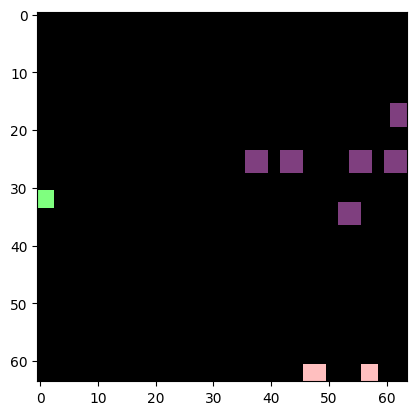

In [17]:
plt.imshow(seg_observations[100])

In [18]:
# conversion using same algorithm as in env
UNIQUE_COLORS = np.array([[  0,   0,   0],
                            [127,  63, 127],
                            [127,  63, 191],
                            [127, 127, 255],
                            [127, 191,  63],
                            [127, 255, 127],
                            [191, 255, 255],
                            [255, 127, 127],
                            [255, 191, 191],
                            [255, 191, 255]], dtype=np.uint8)

POOLER = nn.MaxPool2d(kernel_size=4, stride=4)
mono = th.from_numpy(seg_observations).permute(0, 3, 1, 2)
mono = POOLER(mono.float()).permute(0, 2, 3, 1).numpy().astype(np.uint8)
mono = np.argmax((mono.reshape(-1, 1, 3) == UNIQUE_COLORS).all(axis=2), axis=1).reshape(-1, 16, 16, 1).astype(np.int32)
mono.shape

(10000, 16, 16, 1)

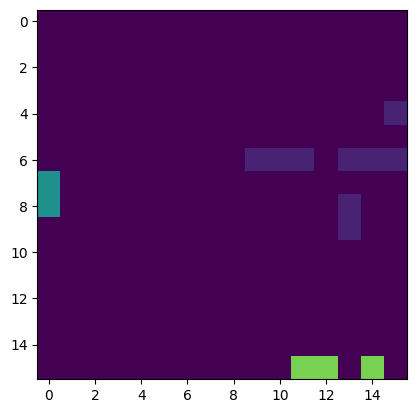

In [19]:
plt.imshow(mono[100], vmin=0, vmax=10)

In [20]:

unique, counts = np.unique(mono, return_counts=True)
unique, counts

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int32),
 array([2292735,   92040,    1796,   11461,     646,   10232,    4015,
           1039,  143650,    2386]))

In [21]:
mono = mono.reshape(-1, 1)

In [22]:
data_extractor = nn.Sequential(
    nn.Dropout(0.1),
    nn.Linear(64, 10),
)

X = th.tensor(features_list, dtype=th.float32)
y = th.tensor(mono[:16*16*DATASET_SIZE], dtype=th.float32)

# mask values where mono is 0
mask = y != 0

X_masked = X[mask.squeeze()]
y_masked = y[mask.squeeze()]

print(y_masked[0])

# add 50% of the data to the dataset from the not masked values
X_masked = th.cat([X_masked, X[~mask.squeeze()][:int(X_masked.shape[0] * 0.5)]])
y_masked = th.cat([y_masked, y[~mask.squeeze()][:int(y_masked.shape[0] * 0.5)]])


# train the data extractor to predict the segment from the features
dataset_features = th.utils.data.TensorDataset(X_masked, y_masked)

# Repeat the data in the dataset
dataset_features = th.utils.data.ConcatDataset([dataset_features]*2)

train_loader = th.utils.data.DataLoader(dataset_features, batch_size=512, shuffle=True, num_workers=4)

optimizer = th.optim.Adam(data_extractor.parameters(), lr=1e-2)
scheduler = th.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[15, 20, 30], gamma=0.1)

epoches = tqdm.tqdm(range(50))
losses = []
for epoch in epoches:
    for features, target in train_loader:
        optimizer.zero_grad()
        output = data_extractor(features)
        # target is int,
        loss = F.cross_entropy(output, target.squeeze().long())
        losses.append(loss.item())
        loss.backward()
        optimizer.step()
    
        if len(losses) > 100:
            epoches.set_description(f"Epoch {epoch} Loss: {np.mean(losses[-100:])}")
        scheduler.step()

tensor([5.])


Epoch 49 Loss: 1.1359618997573853: 100%|██████████| 50/50 [03:15<00:00,  3.90s/it]


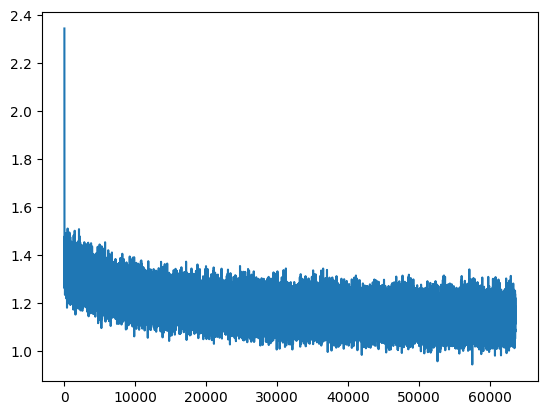

In [23]:
plt.plot(losses)

In [24]:
# try visualizing the output
output = data_extractor(X)
print(output.shape)
output = output.reshape(-1, 16, 16, 10)
output.shape

torch.Size([2048000, 10])


torch.Size([8000, 16, 16, 10])

In [25]:
mono.shape

(2560000, 1)

In [26]:
mono_shaped = mono.reshape(-1, 16, 16, 1)

Text(0.5, 1.0, 'observation')

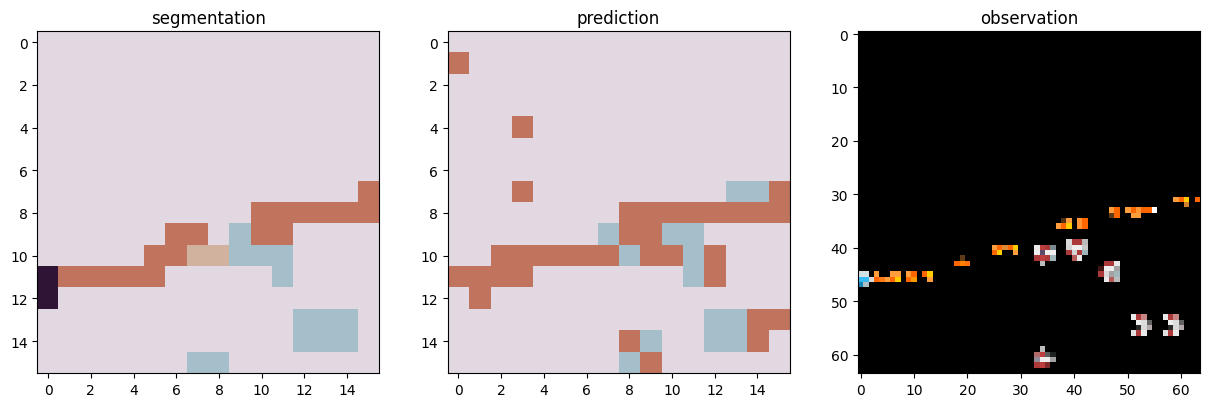

In [27]:
# display
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

I = 60
ax[0].imshow(mono_shaped[I].squeeze(), cmap="twilight", vmin=0, vmax=10, label="segmentation")
ax[0].set_title("segmentation")
ax[1].imshow(output[I].detach().numpy().argmax(axis=2), cmap="twilight", vmin=0, vmax=10, label="prediction")
ax[1].set_title("prediction")
ax[2].imshow(observations[I,:,:,6:], label="observation")
ax[2].set_title("observation")

In [28]:
def generate_visualization_gif(mono_shaped, output, observations, filename='visualization.gif', duration=0.1):
    frames = []
    for I in tqdm.tqdm(range(len(mono_shaped))):
        fig, ax = plt.subplots(1, 3, figsize=(15, 5))
        
        ax[0].imshow(mono_shaped[I].squeeze(), cmap="twilight", vmin=0, vmax=10, label="segmentation")
        ax[0].set_title("segmentation")
        ax[1].imshow(output[I].detach().numpy().argmax(axis=2), cmap="twilight", vmin=0, vmax=10, label="prediction")
        ax[1].set_title("prediction")
        ax[2].imshow(observations[I, :, :, 6:], label="observation")
        ax[2].set_title("observation")
        
        plt.close(fig)
        
        fig.canvas.draw()
        image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
        image = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))
        frames.append(image)
    
    # Save the frames as a GIF
    imageio.mimsave(filename, frames, duration=duration, loop=0)

# Generate the GIF
filename = f'visualization-{MODEL_NAME}.gif'
generate_visualization_gif(mono_shaped[:300], output[:300], observations[:300], filename=filename, duration=0.1)

  0%|          | 0/300 [00:00<?, ?it/s]/tmp/ipykernel_42982/836991560.py:16: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed in 3.10. Use buffer_rgba instead.
  image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
100%|██████████| 300/300 [00:35<00:00,  8.51it/s]


In [ ]:
th.save(data_extractor, f"./models/data_extractor-full-{MODEL_NAME}.pt")